## Tensorflow 2.0 - Power Consumption - Multi-Step Predictions Using RNN-LSTM

- global_active_power: The total active power consumed by the household (kilowatts).
- global_reactive_power: The total reactive power consumed by the household (kilowatts).
- voltage: Average voltage (volts).
- global_intensity: Average current intensity (amps).
- sub_metering_1: Active energy for kitchen (watt-hours of active energy).
- sub_metering_2: Active energy for laundry (watt-hours of active energy).
- sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

#### Active Power Uses Prediction

- What can we predict
 - Forecast hourly consumption for the next day.
 - Forecast daily consumption for the next week.
 - Forecast daily consumption for the next month.
 - Forecast monthly consumption for the next year.
 - Modeling Methods
 
There are many modeling methods and few of those are as follows

- Naive Methods -> Naive methods would include methods that make very simple, but often very effective assumptions.
- Classical Linear Methods -> Classical linear methods include techniques are very effective for univariate time series forecasting
- Machine Learning Methods -> Machine learning methods require that the problem be framed as a supervised learning problem.
- K-nearest neighbors.
- SVM
- Decision trees
- Random forest
- Gradient boosting machines
- Deep Learning Methods -> combinations of CNN LSTM and ConvLSTM, have proven effective on time series classification tasks
- CNN
- LSTM
- CNN – LSTM

#### Problem Framing:

Given recent power consumption, what is the expected power consumption for the week ahead?
This requires that a predictive model forecast the total active power for each day over the next seven days

A model of this type could be helpful within the household in planning expenditures. It could also be helpful on the supply side for planning electricity demand for a specific household.

Input -> Predict

[Week1] -> Week2

[Week2] -> Week3

[Week3] -> Week4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import nan

In [2]:
data = pd.read_csv("data/household_power_consumption.txt", 
                   sep=";", 
                   parse_dates=True, 
                   low_memory=False)

In [3]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
# Conacatenate Dante and Time
data["Date_Time"] = data["Date"].str.cat(data["Time"], sep=" ")

In [5]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date_Time
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,16/12/2006 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,16/12/2006 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,16/12/2006 17:26:00
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0,16/12/2006 17:27:00
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0,16/12/2006 17:28:00


In [6]:
# Dropping Date and Time from the data as its not needed.
data.drop(["Date", "Time"], inplace=True, axis=1)
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Date_Time
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,16/12/2006 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,16/12/2006 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,16/12/2006 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,16/12/2006 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,16/12/2006 17:28:00


In [7]:
# Converting Date_Time to Index
data.set_index(["Date_Time"], inplace=True)    
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
16/12/2006 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
16/12/2006 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
16/12/2006 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
16/12/2006 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [8]:
# Replacing "?" in our data with nan.
data.replace("?", nan, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [10]:
# Converting all data values into float
data = data.astype("float")

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075259 entries, 16/12/2006 17:24:00 to 26/11/2010 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7+ MB


In [12]:
np.isnan(data).sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [13]:
# Replacing all NAN values to some actual values.
# We will convert any NAN values to the same value from the last available Data_Time.

def fill_missing(data):
    
    one_day = 24*60
    
    for row in range(data.shape[0]):
        
        for col in range(data.shape[1]):
            
            if np.isnan(data[row][col]):
                data[row][col] = data[row-one_day, col]

In [14]:
fill_missing(data.values)

In [15]:
# Now we can see all NAN are replaced.
np.isnan(data).sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [16]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.089418e+00,1.236871e-01,2.408364e+02,4.618401e+00,1.118474e+00,1.291131e+00,6.448635e+00
std,1.054678e+00,1.125933e-01,3.240051e+00,4.433165e+00,6.141460e+00,5.796922e+00,8.433584e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.526000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [17]:
data.shape

(2075259, 7)

In [18]:
# Parsing Date_time to datetime format and prepare power consumption per day. 
# The current data has consumption for each minutes in a day.
data.to_csv("data/cleaned_household_power_consumption.csv")

In [19]:
dataset = pd.read_csv("data/cleaned_household_power_consumption.csv", 
                      parse_dates=True, 
                      index_col="Date_Time", 
                      low_memory=False)

In [20]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [21]:
dataset.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2010-11-26 21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0
2010-11-26 21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0


## Exploratory Data Analysis

In [22]:
# Summing all values based on day. "D" is used for day.
data = dataset.resample("D").sum()

In [23]:
# Now we can see the data os available per day instead of per minutes.
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


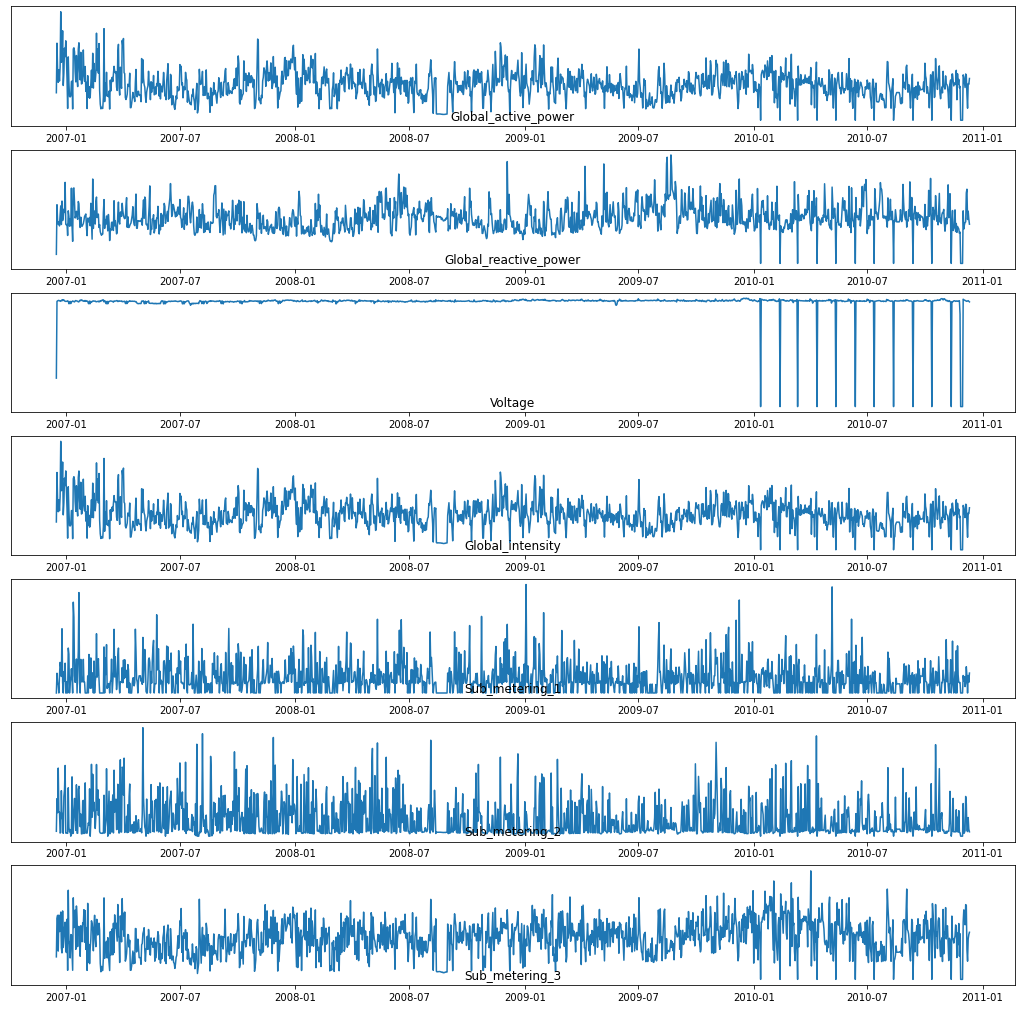

In [24]:
# Plotting some of the data for each column to visualize.
fig, ax = plt.subplots(figsize=(18, 18))

for i in range(len(data.columns)):
    
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    plt.plot(data[name])
    plt.title(name, y=0)
    plt.yticks([])
    
plt.show()
fig.tight_layout()

In [25]:
# We are only intrested in Global Active Power. So lets plot the graph for it for aall years.
years = ["2007", "2008", "2009", "2010"]

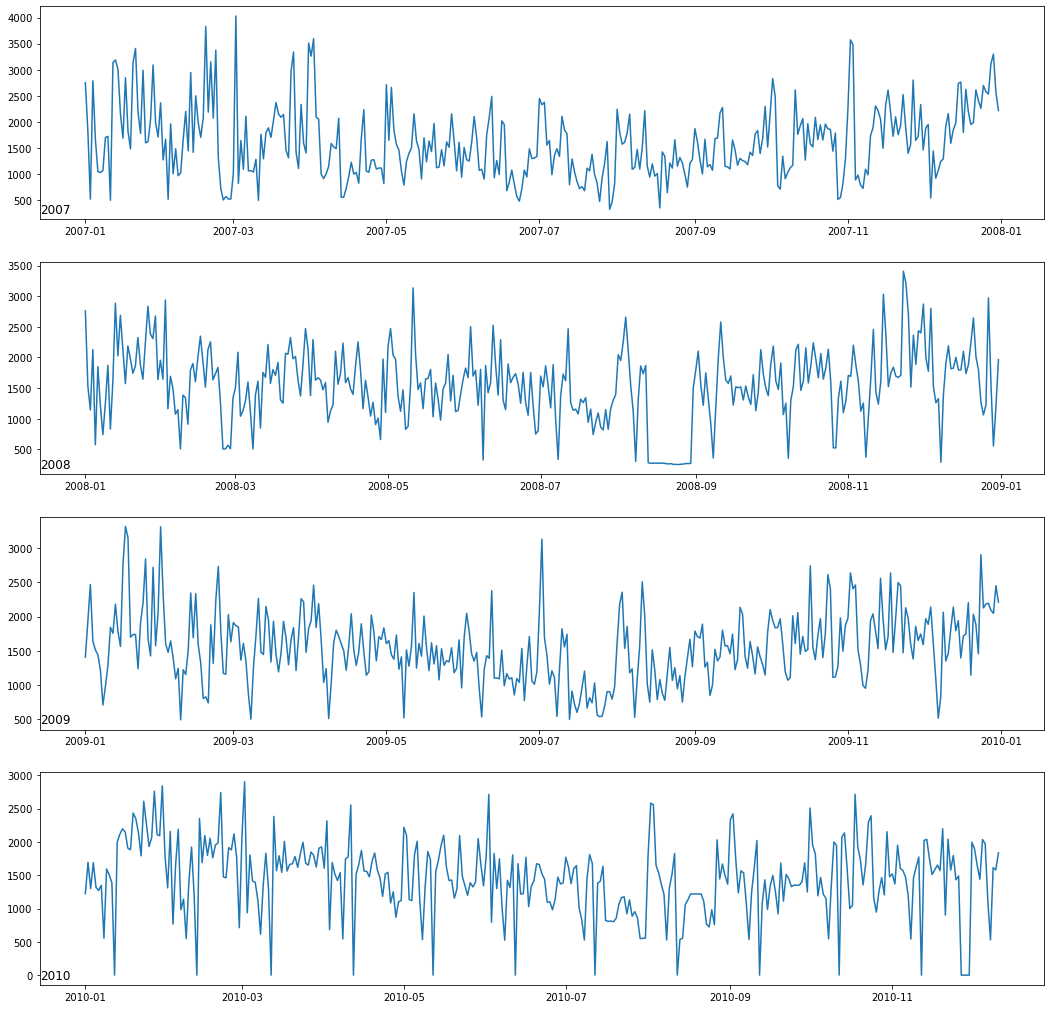

In [26]:
# Plotting data for Global Active Power to visualize for each years.
fig, ax = plt.subplots(figsize=(18, 18))

for i in range(len(years)):
    
    ax = plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    plt.plot(active_power_data["Global_active_power"])
    plt.title(str(year), y=0, loc="left")
    
plt.show()
fig.tight_layout()

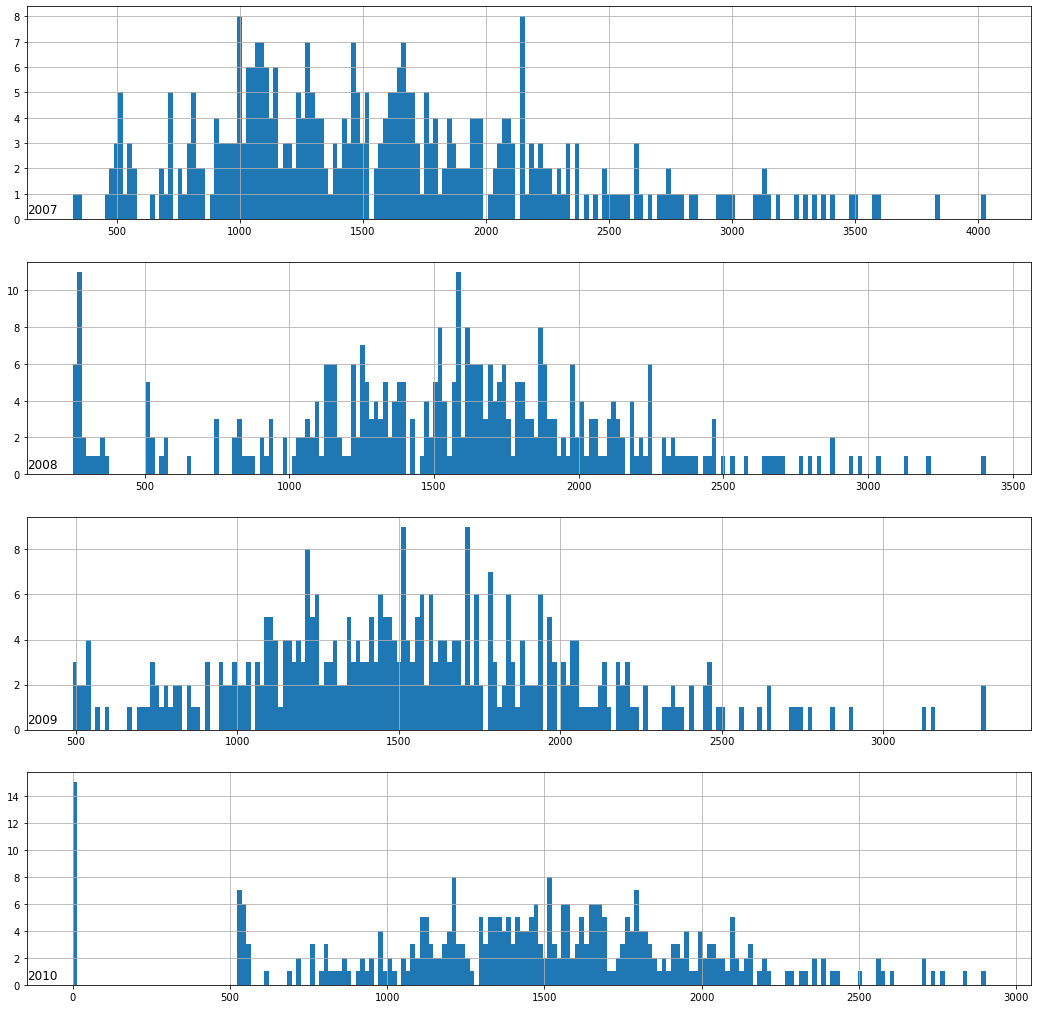

In [27]:
# Visualize using Histogram
# Plotting data for Global Active Power to visualize for each years.
fig, ax = plt.subplots(figsize=(18, 18))

for i in range(len(years)):
    
    ax = plt.subplot(len(years), 1, i+1)
    year = years[i]
    active_power_data = data[str(year)]
    active_power_data["Global_active_power"].hist(bins=200)
    plt.title(str(year), y=0, loc="left")
    
plt.show()
fig.tight_layout()

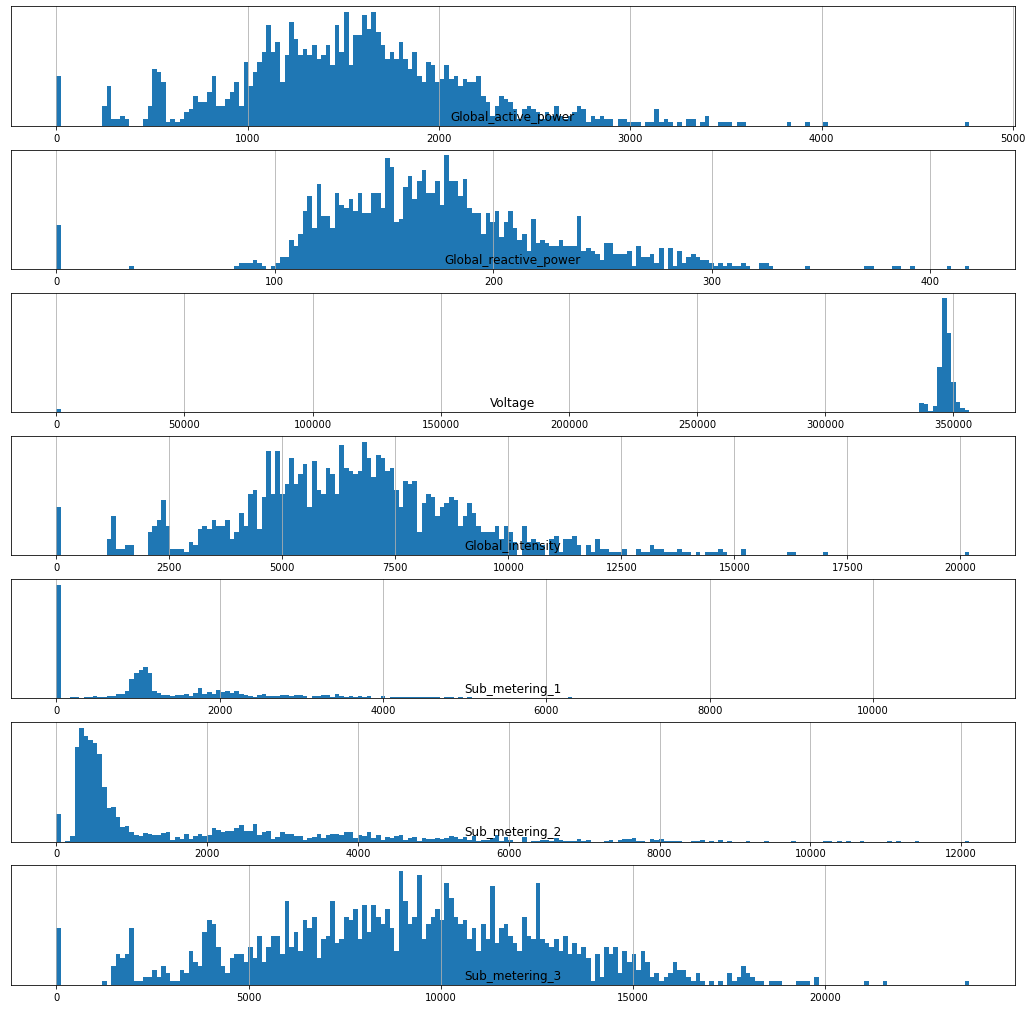

In [28]:
# Plotting histogram for full data
fig, ax = plt.subplots(figsize=(18, 18))

for i in range(len(data.columns)):
    
    plt.subplot(len(data.columns), 1, i+1)
    name = data.columns[i]
    data[name].hist(bins=200)
    plt.title(name, y=0)
    plt.yticks([])
    
plt.show()
fig.tight_layout()

In [29]:
data["2007-01"]["Global_active_power"]

Date_Time
2007-01-01    2749.004
2007-01-02    1824.760
2007-01-03     517.564
2007-01-04    2785.952
2007-01-05    1663.858
2007-01-06    1046.090
2007-01-07    1026.664
2007-01-08    1064.464
2007-01-09    1701.486
2007-01-10    1720.922
2007-01-11     496.216
2007-01-12    3134.942
2007-01-13    3186.814
2007-01-14    3009.442
2007-01-15    2148.678
2007-01-16    1686.404
2007-01-17    2847.688
2007-01-18    1821.462
2007-01-19    1480.440
2007-01-20    3133.732
2007-01-21    3407.262
2007-01-22    2180.494
2007-01-23    1777.640
2007-01-24    2987.854
2007-01-25    1596.344
2007-01-26    1617.972
2007-01-27    2044.072
2007-01-28    3091.588
2007-01-29    1982.664
2007-01-30    1707.798
2007-01-31    2363.752
Freq: D, Name: Global_active_power, dtype: float64

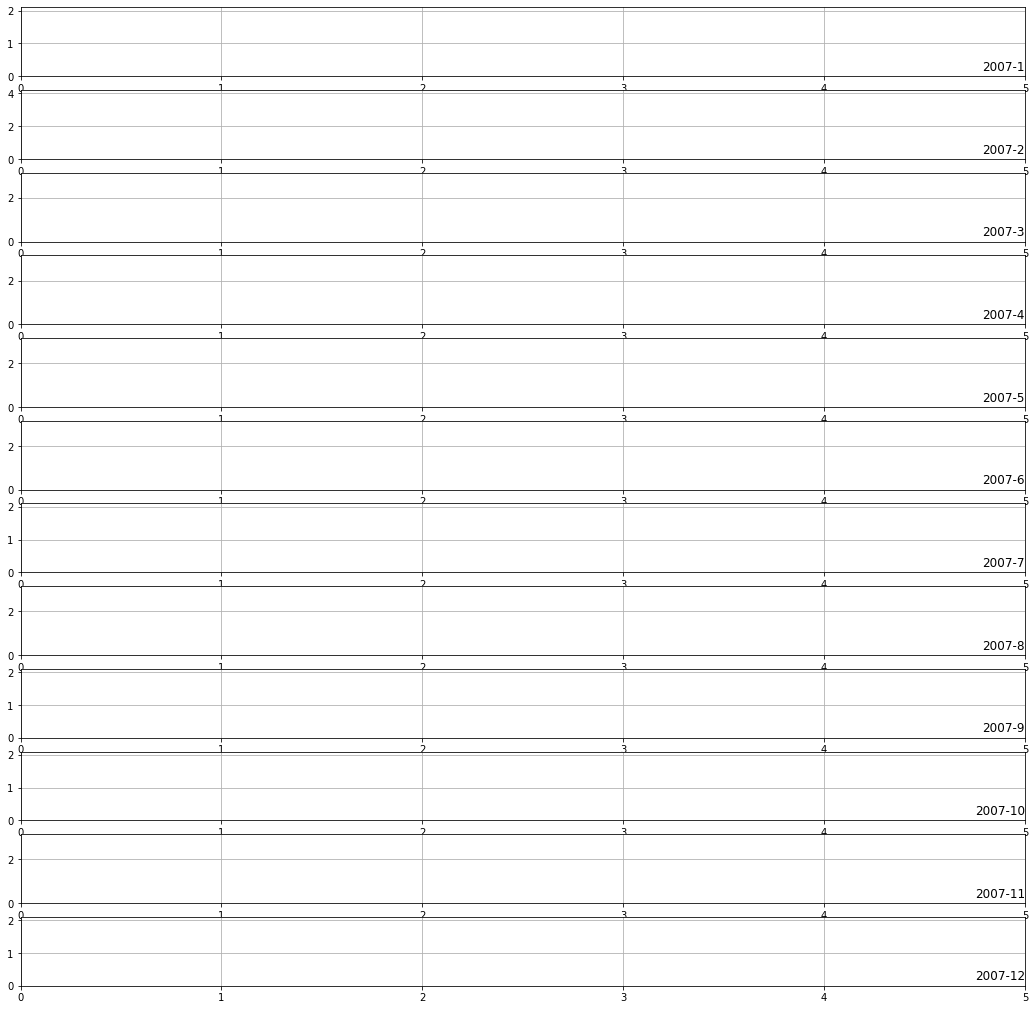

In [30]:
# Plot power consumption histogram for each month of 2007
months = [i for i in range(1, 13)]

fig, ax = plt.subplots(figsize=(18, 18))

for i in range(len(months)):
    ax = plt.subplot(len(months), 1, i+1)
    month = "2007-" + str(months[i])
    active_power_data = data[month]
    active_power_data["Global_active_power"].hist(bins=100)
    ax.set_xlim(0, 5)
    plt.title(month, y=0, loc="right")
    
plt.show()
fig.tight_layout()


In [31]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [33]:
# Before 2010 is Training and after 2010 is Testing dataset.
data_train = data.loc[:"2009-12-31", :]["Global_active_power"]
data_train.head()

Date_Time
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
Freq: D, Name: Global_active_power, dtype: float64

In [34]:
data_test = data["2010"]["Global_active_power"]
data_test.head()

Date_Time
2010-01-01    1224.252
2010-01-02    1693.778
2010-01-03    1298.728
2010-01-04    1687.440
2010-01-05    1320.158
Freq: D, Name: Global_active_power, dtype: float64

In [35]:
data_train.shape, data_test.shape

((1112,), (345,))

In [36]:
# Prepare Training Data.
# 1st 7 days will be input and next 7 days will be output data
data_train.head(14)

Date_Time
2006-12-16    1209.176
2006-12-17    3390.460
2006-12-18    2203.826
2006-12-19    1666.194
2006-12-20    2225.748
2006-12-21    1723.288
2006-12-22    2341.338
2006-12-23    4773.386
2006-12-24    2550.012
2006-12-25    2743.120
2006-12-26    3934.110
2006-12-27    1528.760
2006-12-28    2072.638
2006-12-29    3174.392
Freq: D, Name: Global_active_power, dtype: float64

In [37]:
data_train = np.array(data_train)

In [40]:
x_train, y_train = [], []

for i in range(7, len(data_train)-7):
    x_train.append(data_train[i-7: i])
    y_train.append(data_train[i: i+7])

In [41]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((1098, 7), (1098, 7))

In [42]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6
0,1209.176,3390.460,2203.826,1666.194,2225.748,1723.288,2341.338
1,3390.460,2203.826,1666.194,2225.748,1723.288,2341.338,4773.386
2,2203.826,1666.194,2225.748,1723.288,2341.338,4773.386,2550.012
3,1666.194,2225.748,1723.288,2341.338,4773.386,2550.012,2743.120
4,2225.748,1723.288,2341.338,4773.386,2550.012,2743.120,3934.110
...,...,...,...,...,...,...,...
1093,2138.814,1794.862,1940.116,1394.874,1717.182,1744.706,2204.334
1094,1794.862,1940.116,1394.874,1717.182,1744.706,2204.334,1144.166
1095,1940.116,1394.874,1717.182,1744.706,2204.334,1144.166,2034.966
1096,1394.874,1717.182,1744.706,2204.334,1144.166,2034.966,1888.022


In [43]:
pd.DataFrame(y_train)

,0,1,2,3,4,5,6
0,4773.386,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392
1,2550.012,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108
2,2743.120,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196
3,3934.110,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004
4,1528.760,2072.638,3174.392,2796.108,3494.196,2749.004,1824.760
...,...,...,...,...,...,...,...
1093,1144.166,2034.966,1888.022,1455.200,2905.894,2127.648,2183.618
1094,2034.966,1888.022,1455.200,2905.894,2127.648,2183.618,2195.452
1095,1888.022,1455.200,2905.894,2127.648,2183.618,2195.452,2094.098
1096,1455.200,2905.894,2127.648,2183.618,2195.452,2094.098,2047.968


In [44]:
# Bringing data between 0 and 1
x_scaler = MinMaxScaler()
x_train = x_scaler.fit_transform(x_train)

In [45]:
# Bringing data between 0 and 1
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)

In [47]:
pd.DataFrame(x_train).head(), pd.DataFrame(y_train).head()

(          0         1         2         3         4         5         6
 0  0.211996  0.694252  0.431901  0.313037  0.436748  0.325660  0.462304
 1  0.694252  0.431901  0.313037  0.436748  0.325660  0.462304  1.000000
 2  0.431901  0.313037  0.436748  0.325660  0.462304  1.000000  0.508439
 3  0.313037  0.436748  0.325660  0.462304  1.000000  0.508439  0.551133
 4  0.436748  0.325660  0.462304  1.000000  0.508439  0.551133  0.814446,
           0         1         2         3         4         5         6
 0  1.000000  0.608483  0.659577  0.974702  0.338269  0.482174  0.773688
 1  0.508439  0.659577  0.974702  0.338269  0.482174  0.773688  0.673597
 2  0.551133  0.974702  0.338269  0.482174  0.773688  0.673597  0.858305
 3  0.814446  0.338269  0.482174  0.773688  0.673597  0.858305  0.661134
 4  0.282652  0.482174  0.773688  0.673597  0.858305  0.661134  0.416588)

In [56]:
x_train.shape, y_train.shape

((1098, 7), (1098, 7))

In [57]:
# Converting 2D to 3D data.
x_train = x_train.reshape(1098, 7, 1)

## Build LSTM Model

In [59]:
regressior = Sequential()

regressior.add(LSTM(units=200, activation="relu", input_shape=(7, 1))) # We have 7 timestamps and 1 feature.

regressior.add(Dense(7))

In [60]:
regressior.compile(loss="mse", optimizer="adam")

In [61]:
regressior.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 7)                 1407      
Total params: 163,007
Trainable params: 163,007
Non-trainable params: 0
_________________________________________________________________


In [62]:
regressior.fit(x_train, y_train, epochs=100)

Train on 1098 samples
Epoch 1/100
1098/1098 [==============================] - 6s 6ms/sample - loss: 0.0707
Epoch 2/100
1098/1098 [==============================] - 2s 1ms/sample - loss: 0.0250
Epoch 3/100
1098/1098 [==============================] - 2s 2ms/sample - loss: 0.0241
Epoch 4/100
1098/1098 [==============================] - 2s 1ms/sample - loss: 0.0240
Epoch 5/100
1098/1098 [==============================] - 2s 1ms/sample - loss: 0.0241
Epoch 6/100
1098/1098 [==============================] - 2s 1ms/sample - loss: 0.0240
Epoch 7/100
1098/1098 [==============================] - 2s 1ms/sample - loss: 0.0240
Epoch 8/100
1098/1098 [==============================] - 2s 1ms/sample - loss: 0.0241
Epoch 9/100
1098/1098 [==============================] - 2s 1ms/sample - loss: 0.0238
Epoch 10/100
1098/1098 [==============================] - 2s 1ms/sample - loss: 0.0240
Epoch 11/100
1098/1098 [==============================] - 2s 1ms/sample - loss: 0.0240
Epoch 12/100
1098/1098 [======

1098/1098 [==============================] - 2s 1ms/sample - loss: 0.0229
Epoch 96/100
1098/1098 [==============================] - 2s 2ms/sample - loss: 0.0231
Epoch 97/100
1098/1098 [==============================] - 2s 2ms/sample - loss: 0.0228
Epoch 98/100
1098/1098 [==============================] - 2s 2ms/sample - loss: 0.0230
Epoch 99/100
1098/1098 [==============================] - 2s 2ms/sample - loss: 0.0230
Epoch 100/100
1098/1098 [==============================] - 2s 2ms/sample - loss: 0.0228


In [67]:
# Prepare Test Dataset
data_test = np.array(data_test)

In [71]:
x_test, y_test = [], []

for i in range(7, len(data_test)-7):
    x_test.append(data_test[i-7: i])
    y_test.append(data_test[i: i+7])

In [72]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [73]:
x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [74]:
x_test.shape, y_test.shape

((331, 7), (331, 7))

In [75]:
x_test = x_test.reshape(331, 7, 1)

In [76]:
# Making Predictions
y_pred = regressior.predict(x_test)

In [77]:
y_pred

array([[0.26865983, 0.3339198 , 0.3260497 , ..., 0.3386429 , 0.3206259 ,
        0.32604316],
       [0.18952319, 0.2823958 , 0.291129  , ..., 0.32317674, 0.31230158,
        0.3052081 ],
       [0.27802327, 0.33797768, 0.32967734, ..., 0.32577083, 0.30738747,
        0.3176245 ],
       ...,
       [0.16812283, 0.14922753, 0.1627996 , ..., 0.13109659, 0.13484555,
        0.18655664],
       [0.2810573 , 0.28572106, 0.2581613 , ..., 0.19256869, 0.18514371,
        0.23693117],
       [0.28512543, 0.2960192 , 0.2682544 , ..., 0.21817562, 0.21415795,
        0.25857297]], dtype=float32)

In [78]:
# Inveres Transorming to original data
y_pred = y_scaler.inverse_transform(y_pred)

In [79]:
y_pred

array([[1465.47   , 1512.3224 , 1482.578  , ..., 1530.1731 , 1462.0792 ,
        1482.5533 ],
       [1107.5281 , 1317.5914 , 1350.5979 , ..., 1471.7198 , 1430.618  ,
        1403.8087 ],
       [1507.8217 , 1527.6589 , 1496.2885 , ..., 1481.524  , 1412.0455 ,
        1450.7356 ],
       ...,
       [1010.73236,  814.2921 ,  865.58673, ...,  745.7676 ,  759.9365 ,
         955.3746 ],
       [1521.5448 , 1330.159  , 1225.999  , ...,  978.0967 ,  950.03455,
        1145.7614 ],
       [1539.9454 , 1369.08   , 1264.145  , ..., 1074.8761 , 1059.6918 ,
        1227.5548 ]], dtype=float32)

In [80]:
y_true = y_scaler.inverse_transform(y_test)

In [81]:
y_true

array([[ 555.664, 1593.318, 1504.82 , ...,    0.   , 1995.796, 2116.224],
       [1593.318, 1504.82 , 1383.18 , ..., 1995.796, 2116.224, 2196.76 ],
       [1504.82 , 1383.18 ,    0.   , ..., 2116.224, 2196.76 , 2150.112],
       ...,
       [1892.998, 1645.424, 1439.426, ..., 1973.382, 1109.574,  529.698],
       [1645.424, 1439.426, 2035.418, ..., 1109.574,  529.698, 1612.092],
       [1439.426, 2035.418, 1973.382, ...,  529.698, 1612.092, 1579.692]])

# Evaluate Model

In [82]:
def evaluate_model(y_true, y_predicted):
    scores = []
    
    # Calculate scores for each day
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
        
    # Calculate score for whole predictions
    total_score = 0
    for row in range(y_true.shape[0]):
        for col in range(y_predicted.shape[1]):
            total_score = total_score + (y_true[row, col] - y_predicted[row, col]) ** 2
    total_score = np.sqrt(total_score/(y_true.shape[0] * y_predicted.shape[1]))
    
    return total_score, scores

In [83]:
evaluate_model(y_true, y_pred)

(577.6695478557598,
 [583.4374696564428,
  598.1105473923928,
  574.0469002273628,
  568.6435627233228,
  578.707940729357,
  570.5341064764808,
  569.6330795648724])

In [84]:
# If the scores are less than standard deviation then our model is good.
np.std(y_true[0])

710.0253857243853